In [270]:
import os
import pandas as pd
import numpy as np
import random
from math import ceil
from time import time
import torch
from lightgbm import LGBMClassifier, Dataset

In [183]:
import matplotlib.pyplot as plt

In [184]:
%matplotlib notebook

In [2]:
dataDir= '../../data'
max_hist_len = 12

In [297]:
import gc
gc.collect()

588

In [3]:
print('loading data...')
invite_df = pd.read_csv(os.path.join(dataDir, 'invite_info_1107.csv'),
                        # usecols= ['question_id', 'user_id', 'create_day', 'is_answer'],
                        sep='\t',
                        # nrows= 10000,
                        index_col=0,
                        )
hist_quest_array = np.load(os.path.join(dataDir, 'train_hist_quest_array.npy'))[:, :max_hist_len]
user_df = pd.read_csv(os.path.join(dataDir, 'member_info_1106.csv'),
                      # usecols= ['user_id', 'gender', 'visit_freq', 'binary_A',
                      #        'binary_B', 'binary_C', 'binary_D', 'binary_E',
                      #        'category_A',
                      #        'category_B',
                      #        'category_C',
                      #        'category_D', 'category_E', 'salt_value', 'follow_topics_mp', 'interest_topics'],
                      index_col='user_id',
                      sep='\t',
                      # nrows= 10000,
                      )
user_follow_topics_mp = np.load(os.path.join(dataDir, 'user_follow_topics_mp.npy'))
user_interest_topics_wp = np.load(os.path.join(dataDir, 'interest_topic_wp.npy'))
user_array_dict = {'follow_topics_mp': user_follow_topics_mp,
                   'interest_topics_wp': user_interest_topics_wp
                   }
quest_df = pd.read_csv(os.path.join(dataDir, 'question_info_1111.csv'),
                       # usecols= ['question_id', 'title_SW', 'title_W', 'question_topics_mp', 'title_W_ind', 'create_day',
                       #           'has_describe', 'describe_length'],
                       index_col='question_id',
                       sep='\t',
                       # nrows= 10000
                       )
question_topics_mp = np.load(os.path.join(dataDir, 'question_topics_mp.npy'))
# add one line of zero vector for no exist question
question_topics_mp = np.concatenate([question_topics_mp, np.zeros((1, question_topics_mp.shape[1]))], axis=0)
# np.save(os.path.join(dataDir, 'question_topics_mp.npy'), question_topics_mp)
quest_array_dict = {'question_topics_mp': question_topics_mp}
test_df = pd.read_csv(os.path.join(dataDir, 'test_invite_info_1107.csv'),
                      # usecols= ['question_id', 'user_id', 'create_day'],
                      sep='\t')
test_hist_quest_array = np.load(os.path.join(dataDir, 'test_hist_quest_array.npy'))[:, :max_hist_len]
print('Load data complete.')


loading data...


/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Load data complete.


In [126]:
ans_df = pd.read_csv(os.path.join(dataDir, 'answer_info_1106.csv'), 
                     sep= '\t', 
                     # nrows= 1000,
                     index_col= 'answer_id',
                    )
hist_ans_array = np.load(os.path.join(dataDir, 'train_hist_answ_array.npy'))

In [158]:
ans_df.head()

,question_id,user_id,create_day,create_hour,answer_SW,answer_W,is_good,has_picture,has_video,word_count,num_zan,num_cancel_zan,num_comment,num_collect,num_thanks,num_report,num_useless,num_oppose,answer_index,question_topics_mp
answer_id,,,,,,,,,,,,,,,,,,,,
A2502060945,Q1867533817,M625498202,3808,7,"SW13,SW19,SW44,SW150,SW23,SW594,SW1254,SW91,SW...","W239,W10528,W142,W20372,W6473,W10,W24,W4527,W2...",0,0,0,41,1,0,1,0,1,0,0,0,0,350889
A2847829478,Q3366788616,M142330444,3810,17,"SW898,SW3656,SW2,SW413,SW601,SW2,SW2541,SW681,...","W4628,W66060,W1607,W2647,W53385,W109029,W319,W...",0,0,0,204,1,0,0,3,1,0,0,0,1,1691739
A2005999231,Q4264694221,M771499642,3853,13,"SW9,SW510,SW573,SW1348,SW1304,SW326,SW509,SW22...","W3532,W69108,W12395,W81311,W498,W850,W107789,W...",0,0,0,54,2,0,1,0,0,0,0,0,2,525674
A14821523,Q1088851650,M2282072267,3859,18,"SW7,SW16,SW5,SW144,SW302,SW20,SW1752,SW60,SW75...","W1425,W1676,W3700,W325,W6485,W1090,W8342,W9689...",0,0,0,42,1,0,1,0,1,0,0,0,3,304256
A731550034,Q1023877868,M2282072267,3855,22,"SW7,SW15,SW596,SW407,SW1698,SW68,SW2,SW56,SW59...","W23420,W2610,W5506,W1489,W8749,W504,W1718,W252...",0,0,0,44,0,0,0,0,0,0,0,0,4,1725733


### 检查历史记录是否找错

In [19]:
hist_quest_array[:20]

array([[     -1,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],
       [1738020,      -1,      -1,      -1,      -1,      -1,      -1,
             -1,      -1,      -1,      -1,      -1],


In [20]:
invite_df.head(20)

,create_day,create_hour,create_time,is_answer,is_test,question_id,user_id,answer_id,days_since_last_ans,days_since_last_ans_scaled,create_weekday
8239342,3842,16,D3842-H16,1,0,Q2574396618,M1000000382,A1260717197,12,0.545455,6
5345128,3844,15,D3844-H15,0,0,Q2557202265,M1000000382,NaN,2,0.090909,1
9167807,3846,21,D3846-H21,0,0,Q3910864809,M1000000382,NaN,4,0.181818,3
3507059,3860,21,D3860-H21,0,0,Q1282394327,M1000000382,NaN,18,0.818182,3
736806,3861,17,D3861-H17,0,0,Q4251023727,M1000000382,NaN,19,0.863636,4
1266509,3862,20,D3862-H20,0,0,Q2418257178,M1000000382,NaN,20,0.909091,5
2562710,3865,18,D3865-H18,0,0,Q4038278259,M1000000382,NaN,23,1.045455,1
4155269,3866,21,D3866-H21,0,0,Q3739876694,M1000000382,NaN,24,1.090909,2
3338794,3846,19,D3846-H19,0,0,Q390050321,M1000000983,NaN,16,0.727273,3
6296086,3847,20,D3847-H20,1,0,Q2611259517,M1000000983,A2323857635,17,0.772727,4


In [16]:
quest_df.head()

,create_time,title_SW,title_W,describe_SW,describe_W,question_topics,create_day,create_hour,question_topics_length,question_index,title_W_length,has_describe,describe_W_length,invite_count,invite_count_scaled,question_topics_mp
question_id,,,,,,,,,,,,,,,,
Q2234111670,D1018-H5,"SW211,SW204,SW1715,SW69,SW2033,SW138,SW57,SW13...","W22414,W963,W10458",-1,-1,"T321,T730,T5784,T4389",1018,5,4,0,0.108108,0,0.000000,15.0,0.002680,0
Q760329790,D1745-H20,"SW69,SW2033,SW138,SW2616,SW2668,SW36,SW2594,SW...","W12677,W16829,W15201,W6419,W101839","SW146,SW982,SW401,SW297,SW17,SW2616,SW2668,SW3...","W1296,W2118,W12677,W16829,W15201,W6419,W101839...","T278,T12673,T4677",1745,20,3,1,0.216216,1,0.062863,0.0,0.000000,1
Q741313548,D2032-H21,"SW153,SW662,SW1218,SW853,SW325,SW1056,SW467,SW...","W700,W2781,W3280,W81215","SW1956,SW3583,SW153,SW34,SW35,SW1016,SW586,SW5...","W732,W24400,W48321,W39608,W20788,W219486,W1183...",T226,2032,21,1,2,0.162162,1,0.048356,0.0,0.000000,2
Q3481466230,D2185-H15,"SW22,SW179,SW57,SW451,SW594,SW118,SW882,SW655,...","W3312,W1823,W1505,W638,W166,W461","SW323,SW37,SW1,SW606,SW1227,SW29,SW22,SW179,SW...","W6642,W4214,W3312,W1505,W2205,W232,W294,W7177,...","T51,T4468",2185,15,2,3,0.270270,1,0.116054,1.0,0.000179,3
Q3966197028,D2269-H17,"SW1622,SW223,SW1218,SW853,SW390,SW220,SW753,SW...","W700,W895,W2253",-1,-1,"T54700,T81,T57,T17670,T43574",2269,17,5,4,0.108108,0,0.000000,0.0,0.000000,4


In [22]:
quest_df['question_index'][['Q2574396618','Q2611259517', 'Q1425436837', 'Q2079515575']]

question_id
Q2574396618    1738020
Q2611259517     292966
Q1425436837    1692533
Q2079515575     267896
Name: question_index, dtype: int64

In [170]:
ans_df.loc[['A1260717197', 'A2323857635', 'A411990696'], 'word_count']

answer_id
A1260717197     0
A2323857635    14
A411990696     11
Name: word_count, dtype: int64

In [161]:
hist_ans_array[:20, :3]

array([[     -1,      -1,      -1],
       [ 860889,      -1,      -1],
       [ 860889,      -1,      -1],
       [ 860889,      -1,      -1],
       [ 860889,      -1,      -1],
       [ 860889,      -1,      -1],
       [ 860889,      -1,      -1],
       [ 860889,      -1,      -1],
       [     -1,      -1,      -1],
       [     -1,      -1,      -1],
       [4314573,      -1,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,      -1],
       [4314573, 3816893,  365464]])

#### 无错

### 构造历史回答特征

In [176]:
def construct_hist_sum(feat_name, invalid_value= 0):
    feat_column = np.concatenate([ans_df[feat_name].values, [invalid_value]],axis= 0)
    # print(len(ans_df), len(feat_column))
    hist_feat_array = np.take(feat_column, hist_ans_array)
    invite_df['hist_' + feat_name + '_sum'] = np.sum(hist_feat_array, axis= -1)

In [217]:
def construct_hist_mean(feat_name, invalid_value= 0):
    feat_column = np.concatenate([ans_df[feat_name].values, [invalid_value]],axis= 0)
    # print(len(ans_df), len(feat_column))
    hist_feat_array = np.take(feat_column, hist_ans_array)
    invite_df['hist_' + feat_name + '_mean'] = np.mean(hist_feat_array, axis= -1)

In [178]:
construct_hist_sum('word_count')

In [175]:
invite_df['hist_word_count_sum'].describe()

count    9.306579e+06
mean     2.284500e+02
std      9.321556e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.800000e+01
max      1.168800e+05
Name: hist_word_count_sum, dtype: float64

In [179]:
construct_hist_sum('num_zan')

<IPython.core.display.Javascript object>


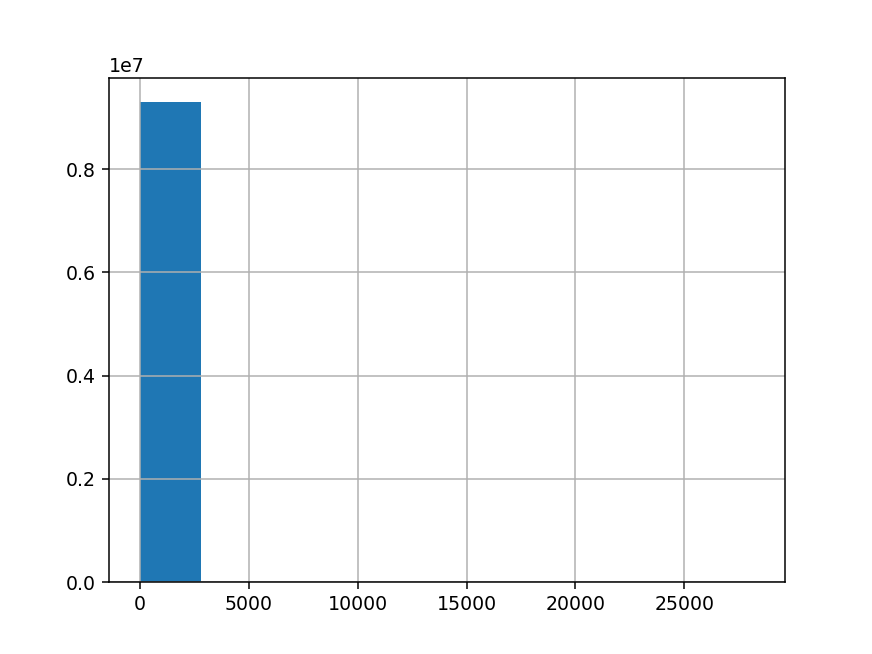

In [185]:
invite_df['hist_num_zan_sum'].hist()

In [181]:
construct_hist_sum('num_thanks')

construct_hist_sum('num_comment')

construct_hist_sum('num_report')

construct_hist_sum('num_useless')

construct_hist_sum('num_collect')

In [220]:
construct_hist_mean('create_hour')

In [229]:
# 历史长度特征
hist_length = hist_quest_array.shape[1] - np.sum(hist_quest_array == -1, axis=-1)
test_hist_length = test_hist_quest_array.shape[1] - np.sum(test_hist_quest_array == -1, axis=-1)
invite_df['hist_length'] = hist_length
test_df['hist_length'] = test_hist_length
hist_length = hist_length.reshape(-1, 1)
test_hist_length = test_hist_length.reshape(-1, 1)

In [232]:
invite_df.to_csv(os.path.join(dataDir, 'invite_info_1118.csv'), sep= '\t')

### 抽取合并特诊

In [234]:
quest_feat_dict = {'sparse': ['has_describe', ],
                   'dense': [
                            'describe_W_length',
                             'title_W_length',
                             'question_topics_length',
                             'invite_count',
                            'question_topics_mp',
                             ]
                   }
# history_feat_dict = {'sparse': {
#     'is_good': 2,
#     'is_recommend': 2,
    # 'has_picture': 2,
    # 'has_video': 2,
# },
#     'dense': {'question_topics_mp': wv_size,
#               'word_count': 1,
#               'num_zan': 1,
#               'num_comment': 1,
#               'num_collect': 1,
#               'num_thanks': 1,
              # 'num_report': 1,
#              'num_useless': 1,
#               'num_oppose': 1
#               }
# }
user_feat_dict = {'sparse': [
    'gender',
    'visit_freq',
    'binary_A',
    'binary_B',
    'binary_C',
    'binary_D',
    'binary_E',
    'category_A',
    'category_B',
    'category_C',
    'category_D',
    'category_E',
],
    'dense': [
        'invite_count',
        'salt_value',
        'follow_topics_mp',
        'interest_topics_wp',
    ]
}

context_feat_dict = {
    'sparse': [
        'create_hour',
        'create_weekday',
    ],
    'dense': [ 
        'hist_num_zan_sum',
        'hist_word_count_sum',
        'hist_num_thanks_sum',
        'hist_num_collect_sum',
        'hist_num_report_sum',
        'hist_num_useless_sum',
        'hist_num_comment_sum',
        'hist_create_hour_mean',
    ]
}


In [235]:
context_feat_names= ['question_id', 'user_id'] + context_feat_dict['sparse'] + context_feat_dict['dense']
quest_feat_names = quest_feat_dict['sparse'] + quest_feat_dict['dense']
user_feat_names = user_feat_dict['sparse'] + user_feat_dict['dense']


In [236]:
quest_feats = quest_df[quest_feat_names]
context_feats = invite_df[context_feat_names]
user_feats = user_df[user_feat_names]
label = invite_df['is_answer']


part_df = pd.merge(context_feats, quest_feats, left_on= 'question_id', right_index=True,  how= 'left', validate='many_to_one')
data = pd.merge(part_df, user_feats, left_on= 'user_id', right_index= True, how= 'left', validate= 'many_to_one')


assert len(data) == len(invite_df)

In [237]:
data.head()

,question_id,user_id,create_hour,create_weekday,hist_num_zan_sum,hist_word_count_sum,hist_num_thanks_sum,hist_num_collect_sum,hist_num_report_sum,hist_num_useless_sum,...,binary_E,category_A,category_B,category_C,category_D,category_E,invite_count_y,salt_value,follow_topics_mp,interest_topics_wp
8239342,Q2574396618,M1000000382,16,6,0,0,0,0,0,0,...,0,19,99,142,135,1,8.0,0.299371,1775003,1775003
5345128,Q2557202265,M1000000382,15,1,0,0,0,0,0,0,...,0,19,99,142,135,1,8.0,0.299371,1775003,1775003
9167807,Q3910864809,M1000000382,21,3,0,0,0,0,0,0,...,0,19,99,142,135,1,8.0,0.299371,1775003,1775003
3507059,Q1282394327,M1000000382,21,3,0,0,0,0,0,0,...,0,19,99,142,135,1,8.0,0.299371,1775003,1775003
736806,Q4251023727,M1000000382,17,4,0,0,0,0,0,0,...,0,19,99,142,135,1,8.0,0.299371,1775003,1775003


In [238]:
len(data)

9306579

In [109]:
def cal_consine_distance(row):
    vec_1 = user_array_dict['follow_topics_mp'][row['follow_topics_mp']]
    vec_2 =  quest_array_dict['question_topics_mp'][row['question_topics_mp']]
    inner_prod = np.dot(vec_1, vec_2)
    f_1 = np.linalg.norm(vec_1)
    f_2 = np.linalg.norm(vec_2)
    f_12 = f_1 * f_2
    f12 = f_12 if f_12 != 0 else 1E-9
    return inner_prod / f12

In [239]:
data['question2user_cosine_distance'] = data[['follow_topics_mp', 'question_topics_mp']].apply(cal_consine_distance, axis = 1)

data['question2user_cosine_distance'].head()

8239342    0.248500
5345128   -0.135085
9167807    0.061958
3507059    0.193367
736806    -0.019707
Name: question2user_cosine_distance, dtype: float64

In [240]:
def cal_eucilid_distance(row):
    vec_1 = user_array_dict['follow_topics_mp'][row['follow_topics_mp']]
    vec_2 =  quest_array_dict['question_topics_mp'][row['question_topics_mp']]
    dist = np.linalg.norm(vec_1 - vec_2)
    return dist

In [241]:
data['question2user_eucilid_distance'] = data[['follow_topics_mp', 'question_topics_mp']].apply(cal_eucilid_distance, axis = 1)
data['question2user_eucilid_distance'].head()

8239342    33.578898
5345128    36.780570
9167807    40.391019
3507059    35.659843
736806     40.144194
Name: question2user_eucilid_distance, dtype: float64

In [242]:
DAYFIRST= 3838
train_day_range= [DAYFIRST + 15, DAYFIRST + 25]
val_day_range= [DAYFIRST + 25, DAYFIRST + 30]


In [243]:
train_idx = np.logical_and(invite_df['create_day'] >= train_day_range[0], invite_df['create_day'] < train_day_range[1])
val_idx = np.logical_and(invite_df['create_day'] >= val_day_range[0], invite_df['create_day'] < val_day_range[1])
print(np.sum(train_idx), np.sum(val_idx))

3249922 1761472


In [244]:
sparse_feat_names = context_feat_dict['sparse'] + user_feat_dict['sparse'] + quest_feat_dict['sparse']

In [245]:
data.columns

Index(['question_id', 'user_id', 'create_hour', 'create_weekday',
       'hist_num_zan_sum', 'hist_word_count_sum', 'hist_num_thanks_sum',
       'hist_num_collect_sum', 'hist_num_report_sum', 'hist_num_useless_sum',
       'hist_num_comment_sum', 'hist_create_hour_mean', 'has_describe',
       'describe_W_length', 'title_W_length', 'question_topics_length',
       'invite_count_x', 'question_topics_mp', 'gender', 'visit_freq',
       'binary_A', 'binary_B', 'binary_C', 'binary_D', 'binary_E',
       'category_A', 'category_B', 'category_C', 'category_D', 'category_E',
       'invite_count_y', 'salt_value', 'follow_topics_mp',
       'interest_topics_wp', 'question2user_cosine_distance',
       'question2user_eucilid_distance'],
      dtype='object')

In [246]:
feat_names = ['create_hour', 'create_weekday',
       'hist_num_zan_sum', 'hist_word_count_sum', 'hist_num_thanks_sum',
       'hist_num_collect_sum', 'hist_num_report_sum', 'hist_num_useless_sum',
       'hist_num_comment_sum', 'hist_create_hour_mean', 'has_describe',
       'describe_W_length', 'title_W_length', 'question_topics_length',
       'invite_count_x', 'gender', 'visit_freq',
       'binary_A', 'binary_B', 'binary_C', 'binary_D', 'binary_E',
       'category_A', 'category_B', 'category_C', 'category_D', 'category_E',
       'invite_count_y', 'salt_value', 'question2user_cosine_distance',
       'question2user_eucilid_distance']

In [247]:
df2use = data[feat_names]

In [284]:
df2use.tail()

,create_hour,create_weekday,hist_num_zan_sum,hist_word_count_sum,hist_num_thanks_sum,hist_num_collect_sum,hist_num_report_sum,hist_num_useless_sum,hist_num_comment_sum,hist_create_hour_mean,...,binary_E,category_A,category_B,category_C,category_D,category_E,invite_count_y,salt_value,question2user_cosine_distance,question2user_eucilid_distance
3858628,10,1,0,194,0,0,0,0,0,1.25,...,0,6,120,75,75,0,6.0,0.415094,0.512398,49.076858
5038932,12,3,0,0,0,0,0,0,0,0.00,...,0,82,69,5,103,1,4.0,0.359748,0.317761,47.696637
8388575,11,2,0,0,0,0,0,0,0,0.00,...,0,82,69,5,103,1,4.0,0.359748,0.226682,49.945389
6528940,14,4,0,0,0,0,0,0,0,0.00,...,0,82,69,5,103,1,4.0,0.359748,0.226682,49.945389
6772170,18,3,0,0,0,0,0,0,0,0.00,...,0,82,69,5,103,1,4.0,0.359748,-0.027304,55.269756


In [285]:
invite_df['days_since_last_ans'].tail()

3858628    15
5038932    23
8388575    29
6528940    31
6772170    37
Name: days_since_last_ans, dtype: int64

In [291]:
df2use['days_since_last_ans'] = invite_df['days_since_last_ans']

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [296]:
df2use.to_csv(os.path.join(dataDir, 'data_df_1118.csv'), sep= '\t')

In [275]:
from lightgbm import early_stopping

In [289]:
model_lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=64, learning_rate=0.1, n_estimators=400,
                           max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                           min_child_weight=5, min_child_samples=10, subsample=0.8, subsample_freq=1,
                           colsample_bytree= 1, seed=1000, n_jobs=32, reg_alpha=3, reg_lambda=5, silent=True, 
                           # is_unbalance= True
                          )

In [292]:
model_lgb.fit(df2use.loc[train_idx], label.loc[train_idx],
              eval_set= [(df2use.loc[val_idx], label.loc[val_idx]), ],
              eval_names= ['validation', ],
              eval_metric= ['auc', 'logloss'],
             categorical_feature = sparse_feat_names,
              early_stopping_rounds= 5
             # callbacks= [early_stopping(5, first_metric_only= True), ]
             )


[1]	validation's binary_logloss: 0.354663	validation's auc: 0.79608
Training until validation scores don't improve for 5 rounds.
[2]	validation's binary_logloss: 0.344478	validation's auc: 0.801126
[3]	validation's binary_logloss: 0.336487	validation's auc: 0.803573
[4]	validation's binary_logloss: 0.330158	validation's auc: 0.806419
[5]	validation's binary_logloss: 0.325008	validation's auc: 0.807614
[6]	validation's binary_logloss: 0.320641	validation's auc: 0.808703
[7]	validation's binary_logloss: 0.316798	validation's auc: 0.809868
[8]	validation's binary_logloss: 0.313677	validation's auc: 0.810648
[9]	validation's binary_logloss: 0.310898	validation's auc: 0.812409
[10]	validation's binary_logloss: 0.308557	validation's auc: 0.813319
[11]	validation's binary_logloss: 0.306408	validation's auc: 0.814593
[12]	validation's binary_logloss: 0.304529	validation's auc: 0.81527
[13]	validation's binary_logloss: 0.30281	validation's auc: 0.816082
[14]	validation's binary_logloss: 0.30144

[118]	validation's binary_logloss: 0.285002	validation's auc: 0.829366
[119]	validation's binary_logloss: 0.285018	validation's auc: 0.829337
Early stopping, best iteration is:
[114]	validation's binary_logloss: 0.284982	validation's auc: 0.829384


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.1, max_bin=425,
        max_depth=-1, min_child_samples=10, min_child_weight=5,
        min_split_gain=0, n_estimators=400, n_jobs=32, num_leaves=64,
        objective='binary', random_state=None, reg_alpha=3, reg_lambda=5,
        seed=1000, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

In [91]:
help(model_lgb.fit)

Help on method fit in module lightgbm.sklearn:

fit(X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_class_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbacks=None) method of lightgbm.sklearn.LGBMClassifier instance
    Build a gradient boosting model from the training set (X, y).
    
    Parameters
    ----------
    X : array-like or sparse matrix of shape = [n_samples, n_features]
        Input feature matrix.
    y : array-like of shape = [n_samples]
        The target values (class labels in classification, real numbers in regression).
    sample_weight : array-like of shape = [n_samples] or None, optional (default=None)
        Weights of training data.
    init_score : array-like of shape = [n_samples] or None, optional (default=None)
        Init score of training data.
    group : array-like or None, optional (default=No

#### 删去topic距离属性

In [97]:
df2use_drop = df2use.drop(columns= ['question2user_distance', 'question2user_eucilid_distance'])

In [94]:
model_lgb_1 = LGBMClassifier(boosting_type='gbdt', num_leaves=64, learning_rate=0.1, n_estimators=2000,
                           max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                           min_child_weight=5, min_child_samples=10, subsample=0.8, subsample_freq=1,
                           colsample_bytree= 0.8, seed=1000, n_jobs=32, silent=True)

In [98]:
model_lgb_1.fit(df2use_drop.loc[train_idx], label.loc[train_idx],
              eval_set= [(df2use_drop.loc[val_idx], label.loc[val_idx]), ],
              eval_names= ['validation', ],
              eval_metric= ['logloss', 'auc'],
             categorical_feature = sparse_feat_names,
             early_stopping_rounds= 5)

[1]	validation's binary_logloss: 0.358057	validation's auc: 0.761709
Training until validation scores don't improve for 5 rounds.
[2]	validation's binary_logloss: 0.350386	validation's auc: 0.76704
[3]	validation's binary_logloss: 0.344482	validation's auc: 0.768448
[4]	validation's binary_logloss: 0.339714	validation's auc: 0.770172
[5]	validation's binary_logloss: 0.335678	validation's auc: 0.771694
[6]	validation's binary_logloss: 0.33243	validation's auc: 0.77259
[7]	validation's binary_logloss: 0.329618	validation's auc: 0.77397
[8]	validation's binary_logloss: 0.327214	validation's auc: 0.775146
[9]	validation's binary_logloss: 0.325139	validation's auc: 0.776418
[10]	validation's binary_logloss: 0.323435	validation's auc: 0.777117
[11]	validation's binary_logloss: 0.321919	validation's auc: 0.777924
[12]	validation's binary_logloss: 0.320659	validation's auc: 0.778511
[13]	validation's binary_logloss: 0.319546	validation's auc: 0.779133
[14]	validation's binary_logloss: 0.318572

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
        importance_type='split', learning_rate=0.1, max_bin=425,
        max_depth=-1, min_child_samples=10, min_child_weight=5,
        min_split_gain=0, n_estimators=2000, n_jobs=32, num_leaves=64,
        objective='binary', random_state=None, reg_alpha=3, reg_lambda=5,
        seed=1000, silent=True, subsample=0.8, subsample_for_bin=50000,
        subsample_freq=1)

#### 删去话题距离属性后 auc 低了0.2个百分点
#### 话题属性有用，但作用很小

### 预测

In [196]:
test_hist_ans_array = np.load(os.path.join(dataDir, 'test_hist_ans_array.npy'))

In [197]:
def construct_test_hist_sum(feat_name, invalid_value= 0):
    feat_column = np.concatenate([ans_df[feat_name].values, [invalid_value]],axis= 0)
    # print(len(ans_df), len(feat_column))
    hist_feat_array = np.take(feat_column, test_hist_ans_array)
    test_df['hist_' + feat_name + '_sum'] = np.sum(hist_feat_array, axis= -1)

In [207]:
def construct_test_hist_mean(feat_name, invalid_value= 0):
    feat_column = np.concatenate([ans_df[feat_name].values, [invalid_value]],axis= 0)
    # print(len(ans_df), len(feat_column))
    hist_feat_array = np.take(feat_column, test_hist_ans_array)
    test_df['hist_' + feat_name + '_mean'] = np.mean(hist_feat_array, axis= -1)

In [199]:
construct_test_hist_sum('word_count')

In [200]:
invite_df['hist_word_count_sum'].describe()

count    9.306579e+06
mean     2.284500e+02
std      9.321556e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      9.800000e+01
max      1.168800e+05
Name: hist_word_count_sum, dtype: float64

In [203]:
construct_test_hist_sum('num_zan')

<IPython.core.display.Javascript object>


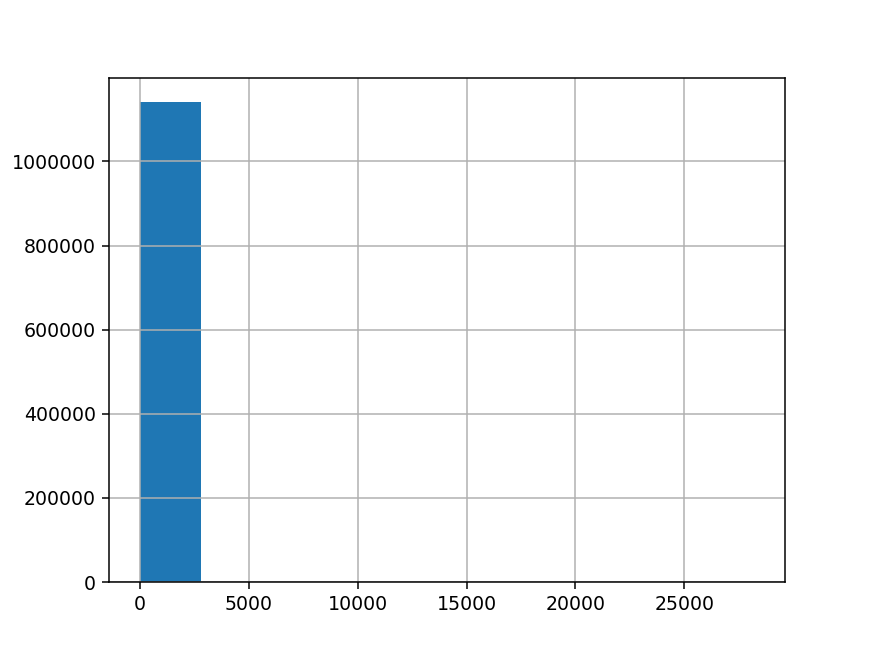

In [204]:
test_df['hist_num_zan_sum'].hist()

In [205]:
construct_test_hist_sum('num_thanks')

construct_test_hist_sum('num_comment')

construct_test_hist_sum('num_report')

construct_test_hist_sum('num_useless')

construct_test_hist_sum('num_collect')

construct_test_hist_mean('create_hour')

In [215]:
test_df.head()

,Unnamed: 0,create_day,create_hour,create_time,is_answer,is_test,question_id,user_id,answer_id,days_since_last_ans,days_since_last_ans_scaled,create_weekday,hist_word_count_sum,hist_num_zan_sum,hist_num_thanks_sum,hist_num_comment_sum,hist_num_report_sum,hist_num_useless_sum,hist_num_collect_sum,hist_create_hour_mean
0,10207568,3869,21,D3869-H21,0,1,Q4280175724,M1000000382,NaN,27,1.227273,5,0,0,0,0,0,0,0,0.68750
1,9840500,3870,18,D3870-H18,0,1,Q920413653,M1000000382,NaN,28,1.272727,6,0,0,0,0,0,0,0,0.68750
2,10594241,3871,19,D3871-H19,0,1,Q1094985150,M1000000983,NaN,14,0.636364,0,33,0,0,0,0,0,0,0.78125
3,9653251,3874,8,D3874-H8,0,1,Q3860309454,M1000013570,NaN,44,2.000000,3,0,0,0,0,0,0,0,0.00000
4,9860201,3869,22,D3869-H22,0,1,Q3209438201,M1000020034,NaN,39,1.772727,5,0,0,0,0,0,0,0,0.00000


In [233]:
test_df.to_csv(os.path.join(dataDir, 'test_info_1118.csv'), sep= '\t')

In [253]:

test_context_feats = test_df[context_feat_names]

test_part_df = pd.merge(test_context_feats, quest_feats, left_on= 'question_id', right_index=True,  how= 'left', validate='many_to_one')
test_data = pd.merge(test_part_df, user_feats, left_on= 'user_id', right_index= True, how= 'left', validate= 'many_to_one')


assert len(test_data) == len(test_df)
test_data['question2user_distance'] = test_data[['follow_topics_mp', 'question_topics_mp']].apply(cal_consine_distance, axis = 1)
test_data['question2user_eucilid_distance'] = test_data[['follow_topics_mp', 'question_topics_mp']].apply(cal_eucilid_distance, axis = 1)
test_data2use = test_data[feat_names]

KeyError: "['question2user_cosine_distance'] not in index"

In [293]:
test_data2use['days_since_last_ans'] = test_df['days_since_last_ans']

/home/sc3/miniconda2/envs/ydzhang/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [294]:
pred_values = model_lgb.predict_proba(test_data2use)

### 取第二列

In [295]:
configStr= 'lgbm_1118'
res_df = pd.read_csv(os.path.join(dataDir, 'test_invite_info_1107.csv'),
                      sep= '\t',
                      usecols= ['question_id', 'user_id', 'create_time'])
assert len(pred_values) == len(res_df)
res_df['predict_value'] = pred_values[:, 1]

res_df.to_csv(os.path.join(dataDir, 'result_%s.txt' %(configStr, )), sep= '\t', header= False, index= False,
               columns = ['question_id', 'user_id', 'create_time', 'predict_value'])